## klasyfikacja mnist - konwolucja



### importy i seed

importy, seed żeby wyniki się nie rozjeżdżały, klasyka

### co z poprzedniego zadania się przydało (i co nie)

- normalizacja danych mega ważna, bez tego sieć głupieje
- podział na train/val/test - bez tego nie wiadomo czy model się uczy czy tylko zgaduje
- accuracy wystarcza, bo klasy są równo rozłożone
- loss też warto patrzeć, bo czasem accuracy stoi a loss spada
- kod w funkcjach = mniej bałaganu


In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset, Subset
import random
from torchvision import datasets, transforms
import itertools
import time
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

### dane i podział

wczytuję mnist, normalizuję, dzielę na train/val/test

In [20]:
MEAN, STD = 0.1307, 0.3081
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((MEAN,), (STD,))
])

full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

total_len = len(full_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)
test_len = total_len - train_len - val_len

train_ds, val_ds, test_ds = random_split(full_dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print(f"Rozmiary zbiorów: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")

Rozmiary zbiorów: train=42000, val=9000, test=9000


### szybki rzut oka na dane

wrzucam po jednym obrazku z każdej cyfry, żeby wiedzieć co tu w ogóle jest

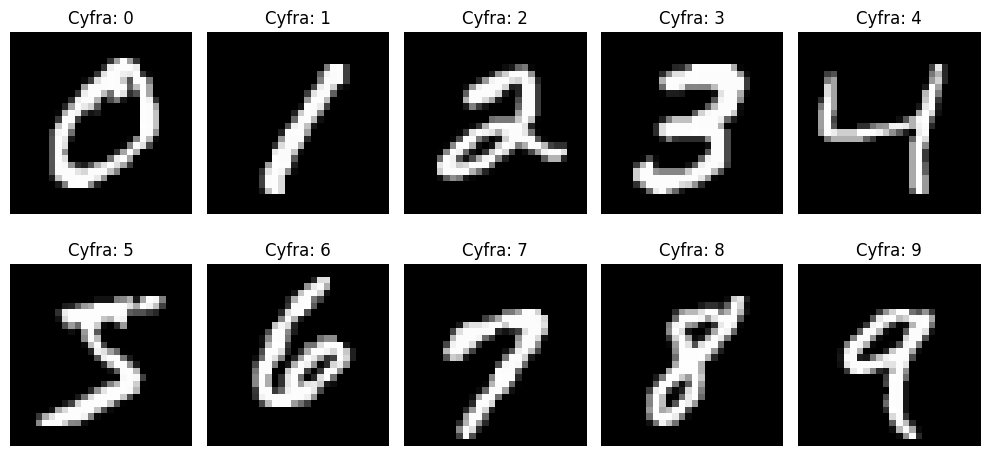

In [21]:
labels = np.array([full_dataset[i][1] for i in range(len(full_dataset))])
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for digit in range(10):
    idx = np.where(labels == digit)[0][0]
    img = full_dataset[idx][0].squeeze()
    ax = axes[digit // 5, digit % 5]
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Cyfra: {digit}')
    ax.axis('off')
plt.tight_layout()
plt.show()

### model bazowy (taki na start)

prosta sieć konwolucyjna, żeby mieć punkt odniesienia, nic wyszukanego

In [22]:
class SimpleCNN(nn.Module):
    def __init__(self, channels=32, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv2d(1, channels, 3, 1)
        self.conv2 = nn.Conv2d(channels, channels*2, 3, 1)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(5*5*channels*2, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.dropout1(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(DEVICE)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### trenowanie i testowanie

funkcje do uczenia i sprawdzania jak idzie, klasyka, kopiuj-wklej

In [23]:
def train(model, device, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += data.size(0)
    return running_loss / total, correct / total

def evaluate(model, device, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += data.size(0)
    return running_loss / total, correct / total

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

### uczenie bazowego modelu

5 epok, patrzymy czy w ogóle coś się uczy

In [24]:
epochs = 5
train_losses, val_losses = [], []
train_accs, val_accs = [], []
for epoch in range(epochs):
    train_loss, train_acc = train(model, DEVICE, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, DEVICE, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoka {epoch+1}/{epochs} | Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

Epoka 1/5 | Train loss: 0.2034, acc: 0.9386 | Val loss: 0.0641, acc: 0.9811
Epoka 2/5 | Train loss: 0.0713, acc: 0.9777 | Val loss: 0.0444, acc: 0.9871
Epoka 2/5 | Train loss: 0.0713, acc: 0.9777 | Val loss: 0.0444, acc: 0.9871
Epoka 3/5 | Train loss: 0.0521, acc: 0.9833 | Val loss: 0.0384, acc: 0.9883
Epoka 3/5 | Train loss: 0.0521, acc: 0.9833 | Val loss: 0.0384, acc: 0.9883
Epoka 4/5 | Train loss: 0.0420, acc: 0.9866 | Val loss: 0.0369, acc: 0.9884
Epoka 4/5 | Train loss: 0.0420, acc: 0.9866 | Val loss: 0.0369, acc: 0.9884
Epoka 5/5 | Train loss: 0.0361, acc: 0.9881 | Val loss: 0.0370, acc: 0.9891
Epoka 5/5 | Train loss: 0.0361, acc: 0.9881 | Val loss: 0.0370, acc: 0.9891


### wykresy uczenia

jak nie ma wykresu to nie działa, więc tu są

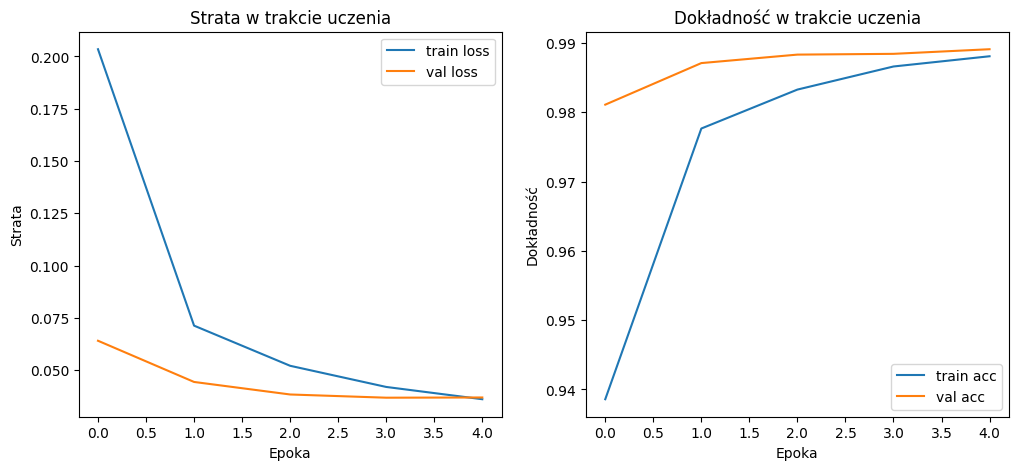

In [25]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()
plt.title('Strata w trakcie uczenia')

plt.subplot(1,2,2)
plt.plot(train_accs, label='train acc')
plt.plot(val_accs, label='val acc')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.title('Dokładność w trakcie uczenia')
plt.show()

### test na testowym

sprawdzam jak model radzi sobie na danych, których nie widział

In [26]:
test_loss, test_acc = evaluate(model, DEVICE, test_loader, criterion)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

Test loss: 0.0435, Test accuracy: 0.9880


### predykcje i pomyłki

kilka predykcji i macierz pomyłek, żeby zobaczyć co model ogarnia, a co nie

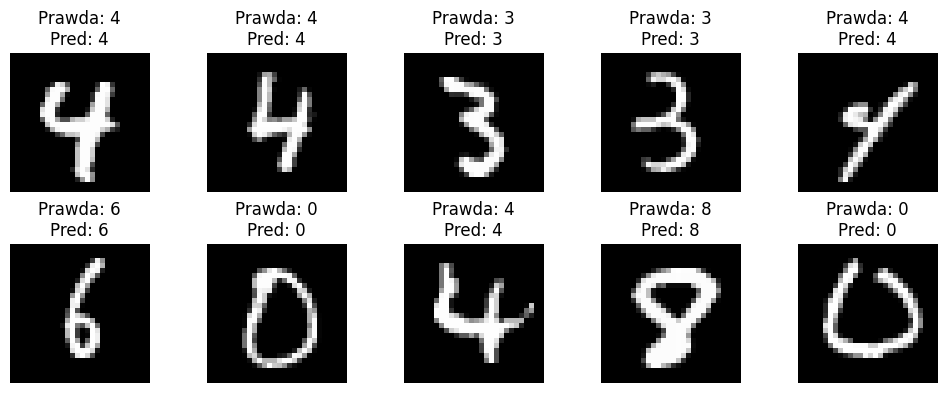

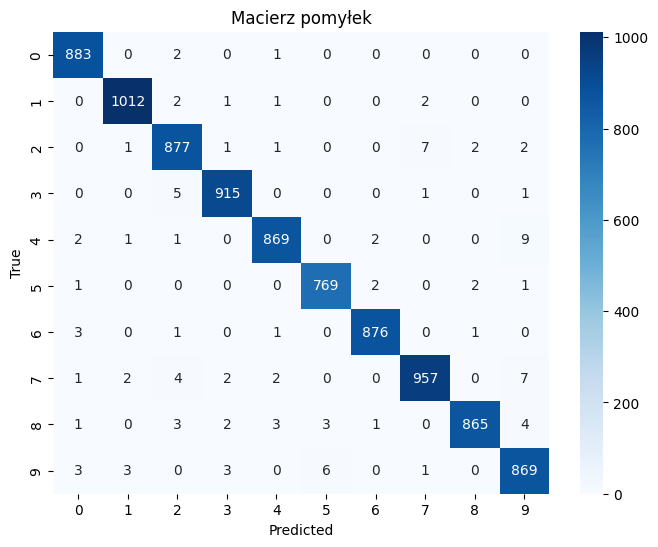

In [27]:
# Przykładowe predykcje
example_data, example_targets = next(iter(test_loader))
example_data = example_data.to(DEVICE)
output = model(example_data)
preds = output.argmax(dim=1)

plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(example_data[i].cpu().squeeze(), cmap='gray')
    plt.title(f"Prawda: {example_targets[i].item()}\nPred: {preds[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Analiza pomyłek
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_targets = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model(data)
        pred = output.argmax(dim=1)
        all_preds.extend(pred.cpu().numpy().flatten())
        all_targets.extend(target.cpu().numpy().flatten())
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Macierz pomyłek')
plt.show()

### Eksperymenty z architekturą

Poniżej możesz łatwo modyfikować architekturę sieci (np. dodać BatchNorm, zmienić dropout, liczbę kanałów/warstw) i sprawdzić wpływ na wyniki.

In [28]:
# AdvancedCNN - rozbudowana architektura konwolucyjna
# Zmiany względem prostego modelu:
# - 3 warstwy konwolucyjne (więcej niż baseline)
# - BatchNorm (opcjonalnie, stabilizuje i przyspiesza uczenie)
# - Dropout (regularyzacja, zapobiega przeuczeniu)
# - Większa liczba kanałów (model ma większą pojemność)
# - Możliwość łatwej modyfikacji parametrów (channels, dropout, use_bn)
# Dzięki temu można testować wpływ architektury na wyniki i lepiej dopasować model do danych.

class AdvancedCNN(nn.Module):
    def __init__(self, channels=32, dropout=0.3, use_bn=True):
        super().__init__()
        self.conv1 = nn.Conv2d(1, channels, 3, 1)
        self.bn1 = nn.BatchNorm2d(channels) if use_bn else nn.Identity()
        self.conv2 = nn.Conv2d(channels, channels*2, 3, 1)
        self.bn2 = nn.BatchNorm2d(channels*2) if use_bn else nn.Identity()
        self.conv3 = nn.Conv2d(channels*2, channels*4, 3, 1)
        self.bn3 = nn.BatchNorm2d(channels*4) if use_bn else nn.Identity()
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(2*2*channels*4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.dropout1(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Przykład użycia (podmień model na AdvancedCNN):
# model = AdvancedCNN(channels=32, dropout=0.3, use_bn=True).to(DEVICE)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# ...trening jak wyżej...

### Wnioski i podsumowanie

- Model baseline osiąga wysoką dokładność, ale najczęściej myli cyfry o podobnych kształtach.
- Dodanie BatchNorm i rozbudowa architektury może poprawić wyniki.
- Warto eksperymentować z liczbą warstw, dropout, optymalizatorami.
- Analiza macierzy pomyłek i przykładowych błędów pomaga zrozumieć ograniczenia modelu.

---

Możesz kopiować i modyfikować kod, by testować różne warianty architektury i hiperparametrów.

### Wszystkie obrazy cyfry 5 i predykcje modelu

Wyświetlamy wszystkie obrazy z testu, które przedstawiają cyfrę 5, wraz z predykcją modelu.

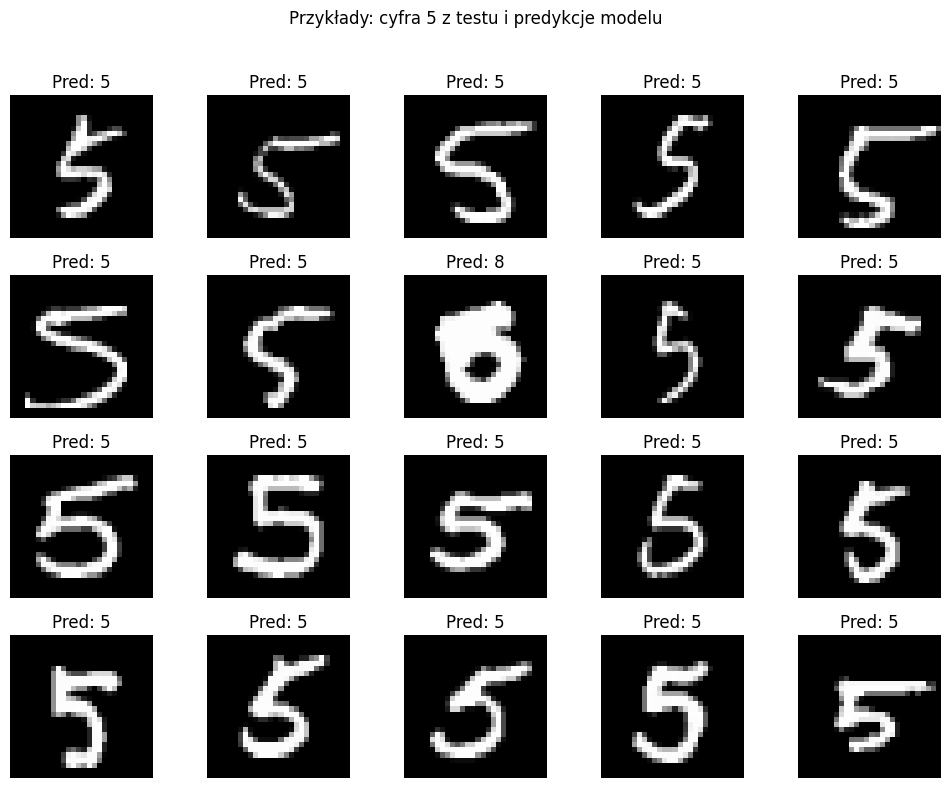

In [29]:
# Zbierz do 20 obrazów 5 z testu
images_5 = []
preds_5 = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        mask = (target == 5)
        if mask.any():
            imgs = data[mask]
            output = model(imgs.to(DEVICE))
            pred = output.argmax(dim=1).cpu()
            for img, p in zip(imgs, pred):
                if len(images_5) < 20:
                    images_5.append(img)
                    preds_5.append(p)
                else:
                    break
        if len(images_5) >= 20:
            break

n = len(images_5)
cols = 5
rows = (n + cols - 1) // cols
plt.figure(figsize=(2*cols, 2*rows))
for i in range(n):
    plt.subplot(rows, cols, i+1)
    plt.imshow(images_5[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {preds_5[i].item()}")
    plt.axis('off')
plt.suptitle('Przykłady: cyfra 5 z testu i predykcje modelu')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
